In [1]:
import torch_geometric as pyg
import os.path as osp
import torch
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pandas import DataFrame
from torch_geometric.data import DataLoader
from torch_geometric.datasets import PPI
from torch_geometric.nn import GCNConv


In [2]:
# path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'PPI')
path = osp.join(osp.abspath(''), '..', 'data', 'PPI')

train_dataset      = PPI(path, split='train')
validation_dataset = PPI(path, split='val')
test_dataset       = PPI(path, split='test')

train_loader      = DataLoader(train_dataset, batch_size=1, shuffle=True)
# batch_size=1 单位是图
validation_loader = DataLoader(validation_dataset, batch_size=2, shuffle=False)
test_loader       = DataLoader(test_dataset, batch_size=2, shuffle= False)

In [3]:
intrain = True

class testNet(torch.nn.Module):
    def __init__(self):
        super(testNet, self).__init__()
        self.conv1 = GCNConv(train_dataset.num_features, 256)
        self.conv2 = GCNConv(256, train_dataset.num_classes)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = F.dropout(x, training=intrain)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

In [11]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model = testNet().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [12]:
def train():
    model.train()
    totalTrainLoss = 0.0
    gcn_PPI_profile = DataFrame(columns=['node_num', 'edge_num', 'max_degree',
                                    'conv1_in_channels', 'conv1_out_channels', 
                                    'conv2_in_channels', 'conv2_out_channels', 
                                    'conv1_agg_time', 'conv1_map_time',
                                    'conv2_agg_time', 'conv2_map_time'
                                   ]
                           )
    for batch in train_loader:
        batch = batch.to(device)
        totalAggTime = 0.0
        totalMapTime = 0.0
        totalAggTime_2 = 0.0
        totalMapTime_2 = 0.0
        for epoch in range(1, 11):
            x, edge_index = batch.x, batch.edge_index
            num_graphs = batch.num_graphs
            optimizer.zero_grad()
            pred = model(x, edge_index)
            loss = loss_op(pred, batch.y)
            totalTrainLoss += loss.item() * num_graphs
            
            totalAggTime += model.conv1.aggregateTime
            totalMapTime += model.conv1.mappingTime
            totalAggTime_2 += model.conv2.aggregateTime
            totalMapTime_2 += model.conv2.mappingTime
            
            loss.backward()
            optimizer.step()
#         log = 'batch_node_num:{:d}, batch_edge_num:{:d}, Loss:{:f}, Agg_time:{:f}, Map_time:{:f}'
#         print(log.format(
#                             batch.x.shape[0], 
#                             batch.edge_index[0].shape[0], 
#                             loss.item() * num_graphs, 
#                             model.conv1.aggregateTime * 1e6, 
#                             model.conv1.mappingTime * 1e6
#                         )
#              )
        result = DataFrame([[batch.x.shape[0], batch.edge_index[0].shape[0],
                             np.max(np.bincount(batch.edge_index[0].cpu())),
                             model.conv1.in_channels, model.conv1.out_channels,
                             model.conv2.in_channels, model.conv2.out_channels,
                             totalAggTime / 10 * 1e6, totalMapTime / 10 * 1e6,
                             totalAggTime_2 / 10 * 1e6, totalMapTime_2 / 10 * 1e6
                            ]],
                           columns=['node_num', 'edge_num', 'max_degree',
                                    'conv1_in_channels', 'conv1_out_channels', 
                                    'conv2_in_channels', 'conv2_out_channels', 
                                    'conv1_agg_time', 'conv1_map_time',
                                    'conv2_agg_time', 'conv2_map_time'
                                   ]
                          )
        gcn_PPI_profile = gcn_PPI_profile.append(result)
    return totalTrainLoss/len(train_loader.dataset), gcn_PPI_profile

In [13]:
# gcn_PPI_profile = DataFrame(columns=['node_num',
#                                      'edge_num',
#                                      'in_channels', 
#                                      'out_channels',
#                                      'agg_time',
#                                      'map_time'
#                                     ]
#                            )
# for epoch in range(1, 11):
#     _, epoch_gcn_PPI_profile = train()
#     gcn_PPI_profile = gcn_PPI_profile.append(epoch_gcn_PPI_profile)
_, gcn_PPI_profile = train()
gcn_PPI_profile.to_csv("./gcn_PPI_profile.csv")

In [14]:
# CoraProfile = pd.read_excel("../gcn_Cora_profile.xlsx")
# CiteSeerProfile = pd.read_excel("../gcn_CiteSeer_profile.xlsx")
# PubMedProfile = pd.read_excel("../gcn_PubMed_profile.xlsx")
PPIProfile = pd.read_csv("./gcn_PPI_profile.csv")

In [15]:
PPIProfile['conv1_mapx'] = PPIProfile['node_num'] * PPIProfile['conv1_in_channels'] * PPIProfile['conv1_out_channels']
PPIProfile['conv1_aggx'] = PPIProfile['edge_num'] * PPIProfile['conv1_out_channels']
PPIProfile['conv2_mapx'] = PPIProfile['node_num'] * PPIProfile['conv2_in_channels'] * PPIProfile['conv2_out_channels']
PPIProfile['conv2_aggx'] = PPIProfile['edge_num'] * PPIProfile['conv2_out_channels']

No handles with labels found to put in legend.


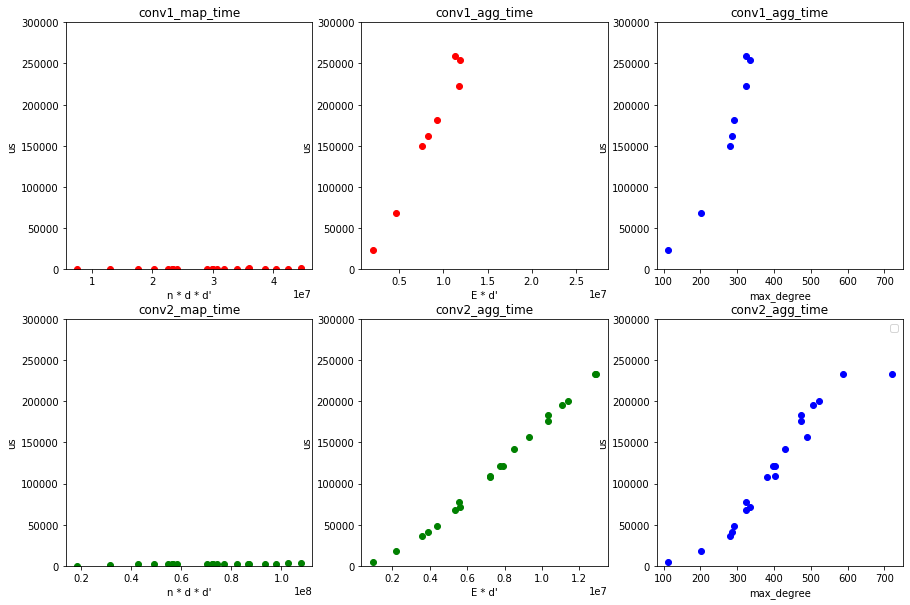

In [17]:

# plt.plot(CoraProfile.epoch, CoraProfile.agg_time, color = "red", linestyle = "--", 
#          label = "Cora_agg_time n_v_aver = 7.8, d = 1443")
# plt.plot(CoraProfile.epoch, CoraProfile.map_time, color = "red", linestyle = "-", 
#          label = "Cora_map_time n_v_aver = 7.8, d = 1443")
# plt.plot(CiteSeerProfile.epoch, CiteSeerProfile.agg_time, color = "green", linestyle = "--", 
#          label = "CiteSeer_agg_time n_v_aver = 5.5, d = 3703")
# plt.plot(CiteSeerProfile.epoch, CiteSeerProfile.map_time, color = "green", linestyle = "-", 
#          label = "CiteSeer_map_time n_v_aver = 5.5, d = 3703")
# plt.plot(PubMedProfile.epoch, PubMedProfile.agg_time, color = "blue", linestyle = "--", 
#          label = "PubMed_agg_time n_v_aver = 9, d = 500")
# plt.plot(PubMedProfile.epoch, PubMedProfile.map_time, color = "blue", linestyle = "-", 
#          label = "PubMed_map_time n_v_aver = 9, d = 500")
gs = matplotlib.gridspec.GridSpec(2,3) 
fig = plt.figure(figsize=(15,10))

conv1_map_plot = fig.add_subplot(gs[0])
conv1_map_plot.set_title("conv1_map_time")
conv1_map_plot.scatter(PPIProfile['conv1_mapx'], PPIProfile['conv1_map_time'], color = 'red')
conv1_map_plot.set_xlabel("n * d * d\'")
conv1_map_plot.set_ylabel("us")
conv1_map_plot.set_ylim(0, 300000) 

conv1_agg_plot = fig.add_subplot(gs[1])
conv1_agg_plot.set_title("conv1_agg_time")
conv1_agg_plot.scatter(PPIProfile['conv1_aggx'], PPIProfile['conv1_agg_time'], color='red')
conv1_agg_plot.set_xlabel("E * d\'")
conv1_agg_plot.set_ylabel("us")
conv1_agg_plot.set_ylim(0, 300000)

conv1_md_agg_plot = fig.add_subplot(gs[2])
conv1_md_agg_plot.set_title("conv1_agg_time")
conv1_md_agg_plot.scatter(PPIProfile['max_degree'], PPIProfile['conv1_agg_time'], color='blue')
conv1_md_agg_plot.set_xlabel("max_degree")
conv1_md_agg_plot.set_ylabel("us")
conv1_md_agg_plot.set_ylim(0, 300000) 


conv2_map_plot = fig.add_subplot(gs[3])
conv2_map_plot.set_title("conv2_map_time")
conv2_map_plot.scatter(PPIProfile['conv2_mapx'], PPIProfile['conv2_map_time'], color = 'green')
conv2_map_plot.set_xlabel("n * d * d\'")
conv2_map_plot.set_ylabel("us")
conv2_map_plot.set_ylim(0, 300000) 

conv2_agg_plot = fig.add_subplot(gs[4])
conv2_agg_plot.set_title("conv2_agg_time")
conv2_agg_plot.scatter(PPIProfile['conv2_aggx'], PPIProfile['conv2_agg_time'], color='green')
conv2_agg_plot.set_xlabel("E * d\'")
conv2_agg_plot.set_ylabel("us")
conv2_agg_plot.set_ylim(0, 300000) 

conv2_md_agg_plot = fig.add_subplot(gs[5])
conv2_md_agg_plot.set_title("conv2_agg_time")
conv2_md_agg_plot.scatter(PPIProfile['max_degree'], PPIProfile['conv2_agg_time'], color='blue')
conv2_md_agg_plot.set_xlabel("max_degree")
conv2_md_agg_plot.set_ylabel("us")
conv2_md_agg_plot.set_ylim(0, 300000) 
# plt.ylabel("us")
plt.legend(loc='upper right')
plt.savefig("../ppi_plot_cpu.png")

In [10]:
np.max(np.bincount(train_dataset.data.edge_index[0]))

1371